In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from graphviz import Digraph

In [2]:
class Node:
    def __init__(self, depth, index, parent=None) -> None:
        self.depth = depth
        self.index = index
        self.parent = parent
        self.left = None
        self.right = None
        self.active = False
        self.mean_estimate = 0.0
        self.proba = 0.0
    
    def subdivide(self):
        self.left = Node(self.depth + 1, 2 * self.index - 1, parent=self)
        self.right = Node(self.depth + 1, 2 * self.index, parent=self)

    def evict(self):
        self.active = False
        if self.left :
            self.left.evict()
        if self.right:
            self.right.evict()

    def contains(self, x):
        left = (self.index-1) / (2**(self.depth-1))
        right = (self.index) / (2 ** (self.depth-1))
        print(left, right)
        return left <= x <= right
    
    def get_parent(self, target_depth):
        """ 
        Enumerate the list of children of a given node
        """
        if target_depth >= self.depth :
            return None
        current = self
        while current and current.depth > target_depth:
            current = current.parent
        return current

    def get_descendants_at_depth(self, target_depth):
        if target_depth <= self.depth :
            return []
        result = []

        def helper(node):
            if node is None :
                return
            if node.depth == target_depth :
                result.append(node)
            elif node.depth < target_depth :
                helper(node.left)
                helper(node.right)
        helper(self)
        return result
    
    def get_active_children(self, target_depth):
        if target_depth <= self.depth :
            return []
        
        result = []

        def dfs(node):
            if node is None :
                return
            if node.depth == target_depth and node.active :
                result.append(node)
            elif node.depth < target_depth :
                dfs(node.left)
                dfs(node.right)
                
        dfs(self)
        return result


    def __repr__(self) -> str:
        return f"Node({self.depth}, {self.index}, {self.active})"

In [3]:
class Tree:

    def __init__(self, max_depth) -> None:
        self.max_depth = max_depth
        self.root = Node(1, 1)
        
        if max_depth is not None:
            self.build_full_tree(node=self.root, max_depth=max_depth)

        self.initialize_active_depth() 

    def build_full_tree(self, node, max_depth):
        """ Build tree of size max_depth recursively with node as root"""
        if node.depth >= max_depth:
            return
        node.subdivide()
        self.build_full_tree(node.left, max_depth)
        self.build_full_tree(node.right, max_depth)

    def initialize_active_depth(self):
        self.active_depths = {}
        active_nodes = self.collect_active_nodes(self.max_depth)
        self.active_depths[self.max_depth] = active_nodes
        self.activate_depth(self.max_depth)

    def activate_depth(self, depth):
        """ 
        Make depth active, i.e. activate all its nodes and add this depth to the set of active depths
        Note that activating one node also actives all its children
        """
        # Activate all children of a given node
        def activate_children(node):
            if not node :
                return
            node.active = True
            activate_children(node.left)
            activate_children(node.right)
        
        # Activate nodes
        def activate_at_depth(node):
            if node is None :
                return
            if node.depth == depth :
                node.active = True
                #activate_children(node.left)
                #activate_children(node.right)
                
            elif node.depth < depth :
                activate_at_depth(node.left)
                activate_at_depth(node.right)

        activate_at_depth(self.root)
        nodes = self.collect_active_nodes(depth)
        self.active_depths[depth] = nodes
        

    def find_node(self, depth, index):
        node = self.root
        for d in range(1, depth):
            if node is None :
                return None
            bit = ((index - 1) >> (depth - d - 1)) & 1
            node = node.right if bit else node.left
        return node if node and node.depth == depth and node.index == index else None
        
    def evict(self, depth, index):
        node = self.find_node(depth, index)
        if node:
            node.evict()
    
    def collect_active_nodes(self, depth):
        def helper_collect_active_nodes(node, depth):
        # base
            if node is None:
                return []
            if node.depth == depth and node.active :
                return [node]
            return helper_collect_active_nodes(node.left, depth) + helper_collect_active_nodes(node.right, depth) 
    
        return helper_collect_active_nodes(self.root, depth)
    
    def count_active_bins(self, depth):
        return len(self.collect_active_nodes(depth))
                
    def update_proba(self):
        """
        Update each node's probability according to the hierarchical sampling scheme.
        Only active nodes at active depths can receive nonzero probabilities.
        """
        # Reset all probabilities to 0
        def reset_probs(node):
            if node is None:
                return
            node.proba = 0.0
            reset_probs(node.left)
            reset_probs(node.right)

        reset_probs(self.root)

        if not self.active_depths:
            return

        active_depths = sorted(self.active_depths.keys())
        min_depth = active_depths[0]
        min_depth_nodes = [n for n in self.active_depths[min_depth] if n.active]

        if not min_depth_nodes:
            return

        base_prob = 1.0 / len(min_depth_nodes)

        # Recursively assign probability only to active children at active depths
        def recurse(node, depth_idx, prob):
            if depth_idx >= len(active_depths):
                return

            current_depth = active_depths[depth_idx]

            if node.depth != current_depth or not node.active:
                return

            node.proba = prob

            # Recurse to next active depth
            if depth_idx + 1 >= len(active_depths):
                return

            next_depth = active_depths[depth_idx + 1]

            # Get all active children of `node` at the next active depth
            children_at_next = node.get_descendants_at_depth(next_depth)
            active_children = [child for child in children_at_next if child.active]

            if not active_children:
                return

            child_prob = prob / len(active_children)

            for child in active_children:
                recurse(child, depth_idx + 1, child_prob)

        for node in min_depth_nodes:
            recurse(node, 0, base_prob)

        
    def update_estimates(self, x_t, y_t):

        def update_node(node):
            if node is None:
                return      
            
            if node.contains(x_t):
                print(f'{node} contains')
                if not node.active :
                    node.mean_estimate = 0.0
                else :
                    p = node.proba
                    node.mean_estimate = (y_t/p)

            update_node(node.left)
            update_node(node.right)
            
        update_node(self.root)

    def visualize_tree(self, filename="dyadic_tree"):
            
            dot = Digraph()

            def add_nodes_edges(node):
                if node is None:
                    return
                # Color node based on activity
                color = "green" if node.active else "red"
                label = f"p={np.round(node.proba, 2)}, {np.round(node.mean_estimate, 3)}"
                dot.node(name=str(id(node)), label=label, style="filled", fillcolor=color)

                for child in [node.left, node.right]:
                    if child:
                        dot.edge(str(id(node)), str(id(child)))
                        add_nodes_edges(child)

            add_nodes_edges(self.root)
            dot.render(filename, format="png", cleanup=True)
            print(f"Tree image saved as {filename}.png")

In [4]:
class MBDE :
    def __init__(self, T) -> None:
        self.T = T
        self.t = 1
        self.l = 0 # current episode

    def initialize_episode(self):
        self.l+=1
        self.block = 0
        self.m = 3
        

    def initialize_block(self):
        self.m+=1
        self.ScheduleReplays()
        self.ending_block = self.t + 8**self.m
        self.tree = Tree(self.m)
        self.d_t = {self.m}
        
    def ScheduleReplays(self):

        """ Schedule all replays for a given block of size 8^m
        """
        self.Replays = np.zeros((8**self.m, self.m))
        for s in range(1 + 1, 1 + 8**self.m):
            for d in range(1, self.m): # de 1 à m-1
                if (s-1) % 8**d == 0 :
                    p_s_d = np.sqrt(8 ** d / (s - 1))
                    R_s_d = int(np.random.random() < p_s_d)
                    self.Replays[s, d] = R_s_d

    def get_mask(self):
        self.active_mask = np.zeros_like(self.Replays)

        for d in reversed(range(self.m)):  # Process deeper intervals first (higher priority)
            length = 8**d
            for s in range(8**self.m):
                if self.Replays[s, d] == 1:
                    end = min(s + length, 8**self.m)
                    for t in range(s, end):
                        # Only assign if no deeper interval was already assigned
                        #if not self.active_mask[t].any():
                        self.active_mask[t, d] = 1

    
    def get_active_depths(self):
        """ 
        gives the set of active depths at current round
        """
        print('hello',self.active_mask.shape[0])
        if self.t < 0 or self.t >= self.active_mask.shape[0]:
            raise ValueError('Round s is out of bounds')
        return {self.m}.union({d for d, active in enumerate(self.active_mask[self.t]) if active == 1})
    
    def pull_action(self) :
        pass
    
    def update(self, y_t) :
        self.t+=1
        pass

    def test_stats():
        pass
    
    def check(self):
        if self.t == self.ending_block : # if block ends naturally
            self.initialize_block()
        pass

    def test(self):
        pass

    def plot_active_mask(self):
        """
        Visualizes the active mask with active intervals and markers at start times.
        """
        m = self.active_mask.shape[1]
        T = self.active_mask.shape[0]
        
        plt.figure(figsize=(10, m * 0.6))
        plt.imshow(self.active_mask.T, aspect='auto', cmap='YlOrBr', interpolation='nearest')
        plt.ylabel("Depth")
        plt.xlabel("Time")
        plt.title("Active Intervals Over Time by Depth")
        plt.yticks(ticks=range(1,m), labels=[f"Depth {d}" for d in range(1,m)])

        # Add start markers
        for d in range(1,m):
            previous = 0
            for t in range(T):
                current = self.active_mask[t, d]
                if current == 1 and previous == 0:
                    plt.plot(t, d, marker='o', color='red', markersize=4)
                previous = current

        plt.tight_layout()
        plt.show()
        

In [5]:
algo = MBDE(100)
algo.initialize_episode()
algo.initialize_block()
algo.get_mask()
algo.t = 1400
algo.get_active_depths()

hello 4096


{2, 3, 4}

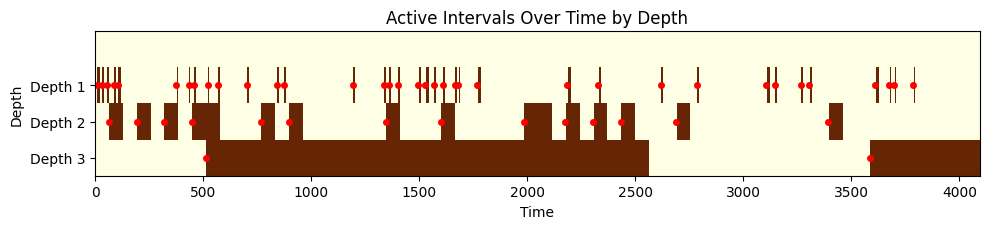

In [6]:
algo.plot_active_mask()

In [324]:

def compute_interval_mask(activation_matrix, m):
    """
    From an activation matrix (starts of intervals), compute a matrix marking active intervals
    (only keeping the deepest one at each time step in case of overlap).
    
    Args:
        activation_matrix: np.array of shape (8**m, m)
        m: depth parameter
    
    Returns:
        active_mask: np.array of shape (8**m, m), where 1 indicates active at that depth and time
    """
    T, D = activation_matrix.shape
    assert T == 8**m and D == m

    active_mask = np.zeros_like(activation_matrix)

    for d in reversed(range(m)):  # Process deeper intervals first (higher priority)
        length = 8**d
        for s in range(T):
            if activation_matrix[s, d] == 1:
                end = min(s + length, T)
                for t in range(s, end):
                    # Only assign if no deeper interval was already assigned
                    if not active_mask[t].any():
                        active_mask[t, d] = 1
    return active_mask





/Users/nicolasnguyen/.pyenv/versions/3.10.4/lib/python3.10/site-packages/matplotlib/image.py:178: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


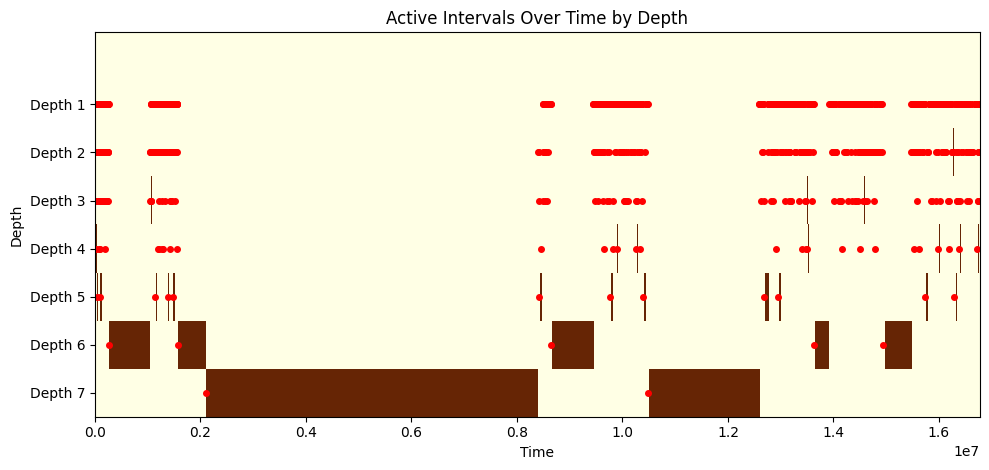

In [325]:
mask = compute_interval_mask(Replays, m)
plot_active_mask(mask)

In [283]:
Replays

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], shape=(4096, 4))

In [281]:
def plot_intervals_by_depth(trigger_matrix, m):
    """
    Plot triggered intervals on parallel lines, one per depth (column),
    coloring each interval differently to distinguish them.
    """
    n_rows, n_cols = trigger_matrix.shape
    fig, ax = plt.subplots(figsize=(12, 1.5 * n_cols))

    color_map = cm.get_cmap('tab20', 100)  # Pick a colormap with many distinct colors
    color_counter = 0

    for d in range(1, n_cols + 1):
        y = n_cols + 1 - d  # So that depth 0 is on top
        for s in range(n_rows):
            if trigger_matrix[s - 1, d - 1] == 1:
                length = 8 ** d
                if s + length <= 8 ** m:
                    color = color_map(color_counter % 200)
                    ax.plot([s, s + length], [y, y], linewidth=6, color=color)
                    color_counter += 1

    ax.set_xlim(0, 8 ** m)
    ax.set_ylim(0.5, n_cols + 0.5)
    ax.set_yticks(range(1, n_cols + 1))
    ax.set_yticklabels([f"depth {d}" for d in reversed(range(n_cols))])
    ax.set_xlabel(f"Timeline [0, {8**m}]")
    ax.set_title("Triggered Intervals by Depth (Color-coded)")
    plt.tight_layout()
    plt.show()


/var/folders/f_/5d1sdz2957q4_tcvztqqz7180000gn/T/ipykernel_1813/3557210119.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', 100)  # Pick a colormap with many distinct colors


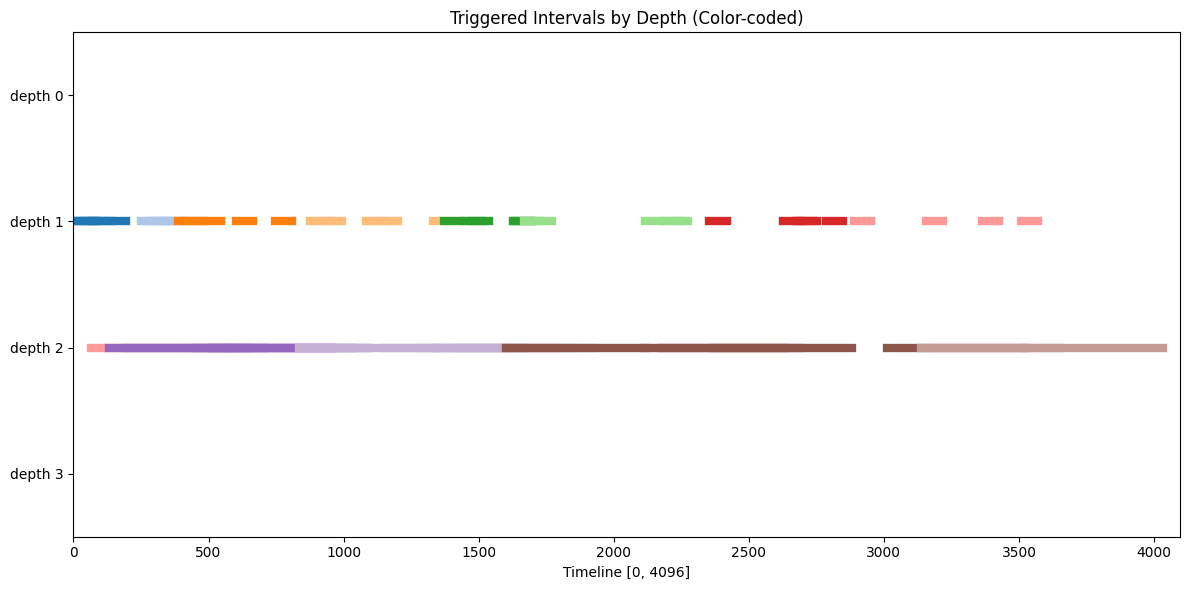

In [282]:
plot_intervals_by_depth(Replays, 4)

In [ ]:
class Environment :
    def __init__(self) -> None:
        pass


In [133]:
tree = Tree(4)
tree.activate_depth(2)
tree.activate_depth(3)
tree.update_proba()
tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [134]:
tree.evict(3, 2)
tree.evict(3, 4)
tree.evict(3, 3)
tree.update_proba()
tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [136]:
tree.update_estimates(0.4, 0.6)
tree.update_proba()
tree.visualize_tree()

0.0 1.0
Node(1, 1, False) contains
0.0 0.5
Node(2, 1, True) contains
0.0 0.25
0.0 0.125
0.125 0.25
0.25 0.5
Node(3, 2, False) contains
0.25 0.375
0.375 0.5
Node(4, 4, False) contains
0.5 1.0
0.5 0.75
0.5 0.625
0.625 0.75
0.75 1.0
0.75 0.875
0.875 1.0
Tree image saved as dyadic_tree.png


In [137]:
tree.evict(4, 4)
tree.update_proba()
tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [56]:
tree.collect_active_nodes(4)

[Node(4, 1, True), Node(4, 3, True), Node(4, 4, True)]

In [55]:
tree.evict(4, 2)
tree.update_proba()
tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [32]:
tree.evict(2, 2)

In [33]:
tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [12]:
tree.activate_depth(2)
tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [ ]:
def sample_replay_prob(m, τ_l_m):
    # Schedule replays for all the block
    Replays = np.zeros((m-1, 8**m - 1 ))
    for s in range(τ_l_m + 1, τ_l_m + 8 ** m):
        for d in range(m):
            if s - τ_l_m % (8 ** d) == 0:
                p_s_d = np.sqrt(8 ** d / (s - τ_l_m))
                R_s_d = int(np.random.random() < p_s_d)
                Replays[s, d] = R_s_d
    return Replays

def MDBE(T):
    # Initialization
    l = 1
    t = 1
    m = 1
    
    while t <= T:
        # (★) Block handling
        if t == 1 or t == τ_l_m + 8 ** m: # if ending of the block without significant shift
            m += 1
            B_MASTER = set(range(1, 1 + 8**m)) # Reset MASTER set
            D_t = {m}
            τ_l_m = t

            # Initialize StoreActive dictionary
            StoreActive = {}
            StoreActive[m] = [τ_l_m, τ_l_m + 8**m]
            for d in range(m) :
                StoreActive[d] = []

            B_t = {}
            Replays = sample_replay_prob(m, τ_l_m)

        # Check if there are replays that are beginning in this precise round t
        for d in range(m) :
            if Replays[t, d] == 1 :
                D_t.add(d)
                StoreActive[d] = [t, t + 8**d]
                B_t[d] = set(range(1, 1 + 8**d))
        
        # Check if a replay ends
        for d in D_t:
            if StoreActive[d][1] == t :
                D_t.discard(d)
                B_t[d] = set()

        # Hierarchical sampling
        d_min = min(D_t)
        B_parent = random.choice(B_t[d_min])

        # faudrait creer une classe d'arbre...
        




        # Replay deactivation
        for d in range(m):
            if StoreActive.get((l, d), {}).get(t, None):
                D[l].discard(d)
                B_t[(l, d)] = set()

        # Bin selection
        d0 = min(D[l])
        B_parent = random.choice(list(B_t[(l, d0)]))
        xt = B_parent  # If no children

        children = get_children(B_parent, d0, B_t)
        if children:
            xt = random.choice(children)
            B_parent = xt

        # Bin eviction
        for d in D[l]:
            for B in B_t[(l, d)]:
                for d_ in [d_ for d_ in range(d + 1, m)]:
                    for B_prime in B_t[(l, d_)]:
                        if bin_condition(B_prime, B, StoreActive, l, d):
                            B_t[(l, d_)] -= {B_prime}

        # MASTER set update
        B_MASTER[(l, m)] = B_MASTER[(l, m)].intersection(B_t.get((l, m), set()))
        if not B_MASTER[(l, m)]:
            τ[(l + 1, 0)] = t + 1
            l += 1
            t = τ[(l, 0)]
            m = 0
            continue

        t += 1


In [15]:
np.log(np.power(10, 6))

np.float64(13.815510557964274)

In [ ]:


def plot_active_mask(active_mask):
    """
    Visualizes the active mask with active intervals and markers at start times.
    """
    m = active_mask.shape[1]
    T = active_mask.shape[0]
    
    plt.figure(figsize=(10, m * 0.6))
    plt.imshow(active_mask.T, aspect='auto', cmap='YlOrBr', interpolation='nearest')
    plt.ylabel("Depth")
    plt.xlabel("Time")
    plt.title("Active Intervals Over Time by Depth")
    plt.yticks(ticks=range(1,m), labels=[f"Depth {d}" for d in range(1,m)])

    # Add start markers
    for d in range(1,m):
        previous = 0
        for t in range(T):
            current = active_mask[t, d]
            if current == 1 and previous == 0:
                plt.plot(t, d, marker='o', color='red', markersize=4)
            previous = current

    plt.tight_layout()
    plt.show()